# Imports

In [2]:
!pip install yellowbrick
!pip install bioinfokit

     |████████████████████████████████| 84 kB 2.2 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56750 sha256=a72b03b76e9f8e3b812093c1bf6fff01f956183e083d09e91eb6aa3e722d40af
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=d8b3165bc9d31de37361546a501f53c38412e342fa2530019a0c130e68cbfad0
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as sch

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import sklearn.cluster as cls
from sklearn.mixture import GaussianMixture

from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA

from sklearn.metrics import mutual_info_score as mutual_info
import bioinfokit

from bioinfokit.analys import stat
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.mixture import GaussianMixture



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
from google.colab import drive
drive.mount('/content/drive')
# ls /content/drive/'My Drive'/

Mounted at /content/drive


# Support Functions

## Display

In [18]:
def style_image(x_label, y_label, fs1=16, fs2=20):
  plt.rcParams["font.family"] = "serif"
  plt.xticks(fontsize=fs1)
  plt.yticks(fontsize=fs1)
  plt.xlabel(x_label, fontsize=fs2, fontweight='bold')
  plt.ylabel(y_label, fontsize=fs2, fontweight='bold')

In [19]:
def GenerateBoxplot(df_all, x_label, y_label, name_image, color1='blue', color2='pink'):
  df_melt = pd.melt(df_all.reset_index(), id_vars=['index'], value_vars=df_all.columns)
  df_melt.columns = ['index', x_label, y_label]  # replace column names

  ax = sns.boxplot(x=x_label, y=y_label, data=df_melt, color=color1)
  ax = sns.swarmplot(x=x_label, y=y_label, data=df_melt, color=color2)

  style_image(x_label, y_label)
  plt.savefig(name_image +'.svg')
  plt.show()
  
  # fs1, fs2 = 16, 20
  # plt.xticks(fontsize=fs1)
  # plt.yticks(fontsize=fs1)
  # ax.set_xlabel(x_label, fontsize=fs2, fontweight='bold')
  # ax.set_ylabel(y_label, fontsize=fs2, fontweight='bold')
  

## Statistical tests

In [20]:
def AnovaTest(x1, x2, x3, x4):
  # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
  f_value, p_value = stats.f_oneway(x1, x2, x3, x4)
  anova_res = pd.DataFrame({'f-value': [f_value], 'p-value': [f'{p_value:.2e}']})
  print('Anova test results:')
  display(anova_res.style.hide_index())
  return(anova_res)


In [21]:
def Ttest(x1, x2):
  # t - test for 2 methods
  t_value,p_value = stats.ttest_ind(x1,x2)
  ttest_res = pd.DataFrame({'t-value': [t_value], 'p-value': [f'{p_value:.2e}']})
  print('t-test results:')
  display(ttest_res.style.hide_index())
  return(ttest_res)

In [22]:
def pair_Ttest(x1, x2):
  #paired t - test for 2 methods
  t_value,p_value = stats.ttest_rel(x1,x2)
  ttest_res = pd.DataFrame({'t-value': [t_value], 'p-value': [f'{p_value:.2e}']})
  print('paired t-test results:')
  display(ttest_res.style.hide_index())
  return(ttest_res)

## More

In [23]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Prepare Data

## Load Data

In [10]:
data_file = r'/content/drive/MyDrive/Colab Notebooks/Unsupervised Learning Project/data/ USCensus1990.data.txt' # for Adir
# data_file = r'/content/drive/My Drive/Colab Notebooks/Unsupervised Learning Project/data//USCensus1990.data.txt' # for Mor
# data_file = r'/content/drive/My Drive/Unsupervised Learning Project/data//USCensus1990.data.txt' # for Yael
original_data = pd.read_csv(data_file, header=None, low_memory=False)

In [11]:
data = original_data.iloc[1:, :]
cols_names = original_data.iloc[0, :]
data.rename(columns=cols_names, inplace=True)
data.drop(["caseid"], axis=1, inplace=True)
# external_veriable = data.filter(["dAge", "dHispanic", "iYearwrk", "iSex"], axis=1)
# data.drop(["dAge", "dHispanic", "iYearwrk", "iSex"], axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Convert To One Hot

In [12]:
cols = (data.columns).tolist()
ext_cols = ['dAge', 'dHispanic', 'iYearwrk', 'iSex']
categorial_cols = [elm for elm in cols if elm not in ext_cols]
data_onehot = pd.get_dummies(data, prefix=categorial_cols, columns=categorial_cols)


## Sample Batches


In [13]:
def SplitToBatchs(data, size_batch, num_batches):
  batches = []
  external_variables = []
  for _ in range(num_batches):
    cur_batch = data.sample(n=size_batch)
    cur_ext_var = cur_batch.filter(["dAge", "dHispanic", "iYearwrk", "iSex"], axis=1)
    external_variables.append(cur_ext_var)
    cur_batch = cur_batch.drop(["dAge", "dHispanic", "iYearwrk", "iSex"], axis=1)
    batches.append(cur_batch)

  return batches, external_variables


In [14]:
# create batches
size_batch, num_batches = 10**4, 10
batches, external_veriable = SplitToBatchs(data_onehot, size_batch, num_batches)

# Clustering

In this section we will test the clustering methods: kmeans, DBscan, GMM and Agglomerative clustering.

## Tunning Parameters

### Kmeans

#### dist

In [ ]:
#KMEANS
def kmeansElbow(data, max_num):
  # calculate kmeans score to range of parameters
  sil = []
  for i in range(4, max_num):
    i_clastering = cls.KMeans(i, random_state=0).fit(data)
    # s_i = silhouette_score(data, i_clastering.labels_)
    s_i = i_clastering.inertia_ # Sum of squared distances of samples to their closest cluster center
    sil.append(s_i)
  return sil

def findKmeansBestParameter(data, max_num):
  # plot elbow method for kmeans 
  y = kmeansElbow(data, max_num)
  x = list(range(4,max_num))
  plt.plot(x,y,marker = "*")
  x_label, y_label = 'Number of clusters', "Loss"
  style_image(x_label, y_label)
  


In [ ]:
for batch in batches:
  findKmeansBestParameter(batch, max_num = 20)
plt.savefig('KmeansTune.svg')
plt.show()
# Not_one_hot From the graphs the best parameter for kmeans: num_cls=8

KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: ignored

#### sil score

In [ ]:
#KMEANS
def kmeansElbow_sil(data, max_num):
  # calculate kmeans score to range of parameters
  sil = []
  for i in range(3, max_num):
    i_clastering = cls.KMeans(i, random_state=0).fit(data)
    s_i = silhouette_score(data, i_clastering.labels_)
    # s_i = i_clastering.inertia_ # Sum of squared distances of samples to their closest cluster center
    sil.append(s_i)
  return sil

def findKmeansBestParameter_sil(data, max_num):
  # plot elbow method for kmeans 
  y = kmeansElbow_sil(data, max_num)
  x = list(range(3,max_num))
  plt.plot(x,y,marker = "*")
  x_label, y_label = 'Number of clusters', "Silhouette Score"
  style_image(x_label, y_label)
  

In [ ]:
for batch in batches:
  findKmeansBestParameter_sil(batch, max_num = 20)
plt.savefig('Kmeans_sil_Tune.svg')
plt.show()
# From the graphs the best parameter for kmeans: num_cls=6

### Dbscan

In [ ]:
min_pts = 2*len(batches[0].columns)
y_label = 'Epsilon'
x_label = 'Loss'
style_image(x_label, y_label)
for batch in batches:
  neighbors = NearestNeighbors(n_neighbors=min_pts)
  neighbors_fit = neighbors.fit(batch)
  distances, indices = neighbors_fit.kneighbors(batch)

  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.savefig('DbscanTune.svg')
  plt.plot(distances[len(distances)//2:])



### Agglomerative

In [ ]:
def best_cluster_graph(data):
  dendrogram = sch.dendrogram(sch.linkage(data, method  = "ward"))
  plt.title('Dendrogram')
  plt.ylabel('Euclidean distances')
  plt.savefig('dendrogram.pdf')
  plt.show()

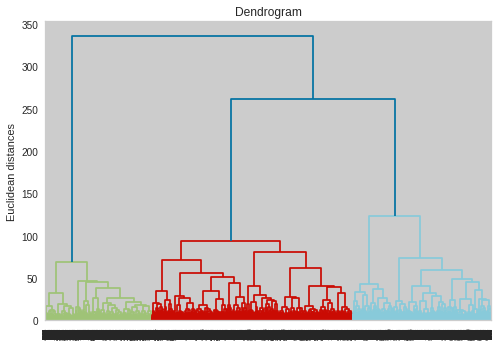

In [ ]:
best_cluster_graph(batches[0])

In [ ]:
# cluster = cls.AgglomerativeClustering(linkage='average', n_clusters=3).fit(batches[0])
# print("Agglomerative: silhouttte: ", silhouette_score(batches[0], cluster.labels_))

### GMM

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)


def GMMElbow_average(batches, max_num):
  # calculate kmeans score to range of parameters
  i_sil_batches = []
  all_sil = []
  for i in range(2, max_num):
      for batch in batches[:1]:
        gmm = GaussianMixture(n_components=i).fit(batch)
        labels = gmm.predict(batch)
        i_cur_sil_batch = silhouette_score(batch, labels)
        i_sil_batches.append(i_cur_sil_batch)
      s_i = Average(i_sil_batches)
      all_sil.append(s_i)
  return all_sil

  
def GMMElbow(batch, max_num):
  # calculate kmeans score to range of parameters
  sil = []
  for i in range(2, max_num):
    gmm = GaussianMixture(n_components=i).fit(batch)
    labels = gmm.predict(batch)
    s_i =  silhouette_score(batch, labels)
    sil.append(s_i)
  return sil


def findGMMBestParameters(batches, max_num):
  # plot elbow method for GMM
  for batch in batches:
    y = GMMElbow(batch, max_num)
    x = list(range(2,max_num))
    plt.plot(x,y,marker = "*")


In [ ]:
findGMMBestParameters(batches, max_num = 10)
x_label = 'Number Of Clusters'
y_label = 'Silhouette Score'
style_image(x_label, y_label)
plt.savefig('GMMTune.svg')
plt.show()

## Comper Clustering

In [15]:
clusters_by_method = {'KMEANS':[], 'DBSCAN':[], 'Agglomerative':[], 'GMM':[]}
for batch in batches:
  cluster = cls.KMeans(6, random_state=0).fit(batch).labels_
  clusters_by_method['KMEANS'].append(cluster)
  cluster = cls.DBSCAN(eps=5, min_samples=736).fit(batch).labels_
  clusters_by_method['DBSCAN'].append(cluster)
  cluster = cls.AgglomerativeClustering(linkage='average', n_clusters=3).fit(batch).labels_
  clusters_by_method['Agglomerative'].append(cluster)
  cluster = GaussianMixture(n_components=3).fit_predict(batch)
  clusters_by_method['GMM'].append(cluster)


### Silhouette Score

In [ ]:
def SampleSil(clusters_by_method, batches):
  criterion = {}
  for method in clusters_by_method:
    labels_by_method = clusters_by_method[method]
    criterion[method] = SIL2Batches(labels_by_method, batches)
  return criterion

def SIL2Batches(labels_by_method, batches):
  sil = []
  for i_batch, labels_batch in enumerate(labels_by_method):
    labels_pred = labels_by_method[i_batch]
    batch = batches[i_batch]
    sil.append( silhouette_score(batch, labels_pred) )
  return sil

In [ ]:
# SIL
sil_score_all_cls = SampleSil(clusters_by_method, batches)
df_sil = pd.DataFrame(sil_score_all_cls)

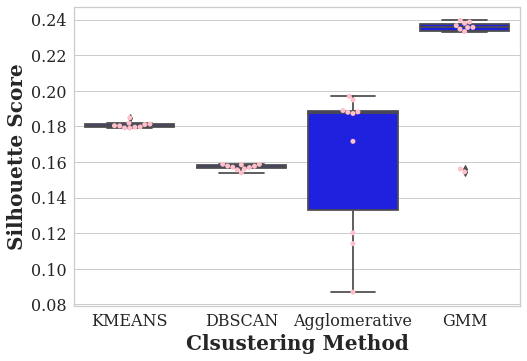

In [ ]:
# boxplot - sil score 
x_label = 'Clsustering Method'
y_label = 'Silhouette Score'
GenerateBoxplot(df_sil, x_label, y_label, name_image='sil score ')


In [ ]:
# tests
anova_res = AnovaTest(df_sil['KMEANS'], df_sil['DBSCAN'], df_sil['Agglomerative'], df_sil['GMM'])
pairttest_res = pair_Ttest(df_sil['KMEANS'], df_sil['GMM'])

Anova test results:


f-value,p-value
11.390648,2.12e-05


paired t-test results:


t-value,p-value
-3.646310,5.35e-03


In [ ]:
print(np.mean([df_sil['KMEANS'],df_sil['DBSCAN'], df_sil['Agglomerative'], df_sil['GMM']]))
print(np.std([df_sil['KMEANS'],df_sil['DBSCAN'], df_sil['Agglomerative'], df_sil['GMM']]))
print(np.mean([df_sil['KMEANS'], df_sil['GMM']]))
print(np.std([df_sil['KMEANS'], df_sil['GMM']]))

0.18042820107700414
0.03518291520630879
0.2004791800953257
0.0303524894380917


### Mutual Infornation

In [30]:
def SampleCriterion(clusters_by_method, ext_labels):
  criterion = {}
  for method in clusters_by_method:
    labels_by_method = clusters_by_method[method]
    criterion[method] = MI2Batchs(labels_by_method, ext_labels)
  return criterion


def MI2Batchs(labels_by_method, ext_labels):
  names_list = ["dAge", "dHispanic", "iYearwrk", "iSex"]
  mi_dAge, mi_dHispanic, mi_iYearwrk, mi_iSex = [], [], [], []
  mi = {"Age":[], "Hispanic":[], "Yearwrk":[], "Sex":[]}
  for i_batch, labels_batch in enumerate(labels_by_method):
    # dAge
    labels_true = ext_labels[i_batch].dAge
    labels_pred = labels_batch
    mi['Age'].append( mutual_info(labels_true, labels_pred) )
    
    # dHispanic
    labels_true = ext_labels[i_batch].dHispanic
    labels_pred = labels_batch
    mi['Hispanic'].append( mutual_info(labels_true, labels_pred) )

    # iYearwrk
    labels_true = ext_labels[i_batch].iYearwrk
    labels_pred = labels_batch
    mi['Yearwrk'].append( mutual_info(labels_true, labels_pred) )

    # iSex
    labels_true = ext_labels[i_batch].iSex
    labels_pred = labels_batch
    mi['Sex'].append( mutual_info(labels_true, labels_pred) )

  return mi



In [31]:
# MI
criterion_mi = SampleCriterion(clusters_by_method, external_veriable)


In [32]:
# for ext_var in ['Age', "Hispanic", "Yearwrk", "Sex"]:
criterion = criterion_mi

ext_var = 'Age'
d = {}
for method in criterion:
  d[method] = criterion[method][ext_var]
df_Age = pd.DataFrame(d)

ext_var = 'Hispanic'
d = {}
for method in criterion:
  d[method] = criterion[method][ext_var]
df_Hispanic = pd.DataFrame(d)

ext_var = 'Yearwrk'
d = {}
for method in criterion:
  d[method] = criterion[method][ext_var]
df_Yearwrk = pd.DataFrame(d)

ext_var = 'Sex'
d = {}
for method in criterion:
  d[method] = criterion[method][ext_var]
df_Sex = pd.DataFrame(d)


In [ ]:
# boxplot - MI
# x_label = 'Clsustering Method'
# y_label = 'Mutual Information'
# for name_df in [df_Age, df_Hispanic, df_Yearwrk, df_Sex]:
#   GenerateBoxplot(name_df, x_label, y_label)


In [39]:
print(df_Age.mean())
print(df_Hispanic.mean())
print(df_Yearwrk.mean())
print(df_Sex.mean())


KMEANS           0.646303
DBSCAN           0.308174
Agglomerative    0.203012
GMM              0.551548
dtype: float64
KMEANS           0.003936
DBSCAN           0.007853
Agglomerative    0.000734
GMM              0.001591
dtype: float64
KMEANS           1.116347
DBSCAN           0.626823
Agglomerative    0.451652
GMM              0.919763
dtype: float64
KMEANS           0.049094
DBSCAN           0.010227
Agglomerative    0.005275
GMM              0.011105
dtype: float64


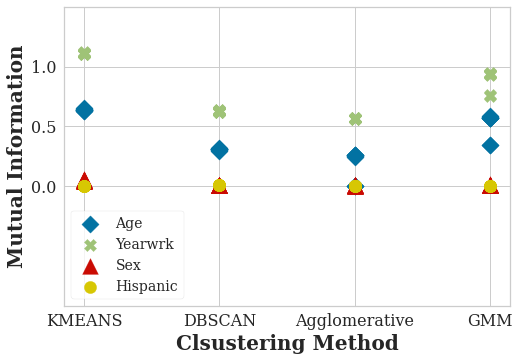

In [ ]:
df_melt = pd.melt(df_Age.reset_index(), id_vars=['index'], value_vars=df_Age.columns)
df_melt.columns = ['index', x_label, y_label]
plt.scatter(x_label, y_label,data=df_melt,label = 'Age', s=150, marker='D')
plt.legend()

df_melt = pd.melt(df_Yearwrk.reset_index(), id_vars=['index'], value_vars=df_Yearwrk.columns)
df_melt.columns = ['index', x_label, y_label]
plt.scatter(x_label, y_label,data=df_melt,label = 'Yearwrk', s=150, marker='X')
plt.legend()

df_melt = pd.melt(df_Sex.reset_index(), id_vars=['index'], value_vars=df_Sex.columns)
df_melt.columns = ['index', x_label, y_label]
plt.scatter(x_label, y_label,data=df_melt, label = 'Sex', s=250, marker='^')


df_melt = pd.melt(df_Hispanic.reset_index(), id_vars=['index'], value_vars=df_Hispanic.columns)
df_melt.columns = ['index', x_label, y_label]
plt.scatter(x_label, y_label,data=df_melt,label = 'Hispanic', s=150, color='y')

plt.legend(frameon=True, loc ="best", prop={'size': 14})
x_label = 'Clsustering Method'
y_label = 'Mutual Information'
style_image(x_label, y_label)
# plt.xlabel('Clsustering Method', fontsize=18)
# plt.ylabel ('Mutual Information', fontsize=18)
plt.ylim(-1, 1.5)
# plt.yscale('log')
plt.yticks(np.arange(0, 1.5, 0.5))
plt.savefig('MI.svg')
plt.show()

In [ ]:
# tests - need to change to MI
# for i in [df_Age,df_Hispanic, df_Yearwrk, df_Sex]:
#   print('----------------------------------------------')
#   anova_res = AnovaTest(i['KMEANS'], i['DBSCAN'], i['Agglomerative'], i['GMM'])
#   pairttest_res = pair_Ttest(i['KMEANS'], i['DBSCAN'])
#   print(np.mean([i['KMEANS'], i['DBSCAN'], i['Agglomerative'], i['GMM']]))
#   print(np.std([i['KMEANS'],i['DBSCAN'], i['Agglomerative'], i['GMM']]))
#   print(np.mean([i['KMEANS'], i['GMM']]))
#   print(np.std([i['KMEANS'], i['GMM']]))

In [ ]:
# tests - need to change to MI
anova_res = AnovaTest(df_Age['GMM'], df_Hispanic['GMM'], df_Yearwrk['GMM'], df_Sex['GMM'])
pairttest_res = pair_Ttest(df_Age['GMM'], df_Yearwrk['GMM'])
print(np.mean([df_Age['GMM'], df_Hispanic['GMM'], df_Yearwrk['GMM'], df_Sex['GMM']]))
print(np.std([df_Age['GMM'], df_Hispanic['GMM'], df_Yearwrk['GMM'], df_Sex['GMM']]))
print(np.mean([df_Age['GMM'], df_Yearwrk['GMM']]))
print(np.std([df_Age['GMM'],df_Yearwrk['GMM']]))

Anova test results:


f-value,p-value
506.800022,1.74e-29


paired t-test results:


t-value,p-value
-52.767446,1.58e-12


0.3611828324286225
0.38274003586599803
0.7157239405756604
0.20384462956083438


# Anomalies 

## Anomalies Detection

In [ ]:
# # asuming the best cls method is agglomerative
# perecent = 5/100 
# i = 0
# df_sil = pd.DataFrame(batches[i])
# num_sampels =  len(batches[i])
# num_row = int(num_sampels*perecent)

# df_sil['sil'] = cluster_by_method['KMEANS'][i]
# df_sil = df_sil.sort_values(by=['sil'])


In [16]:
all_clusters = clusters_by_method['GMM']
sample_scores = []
for batch, batch_clusters in zip(batches ,all_clusters):
  cur_sil = silhouette_samples(batch, batch_clusters)
  batch['sil_score'] = cur_sil
  sample_scores.extend(cur_sil)


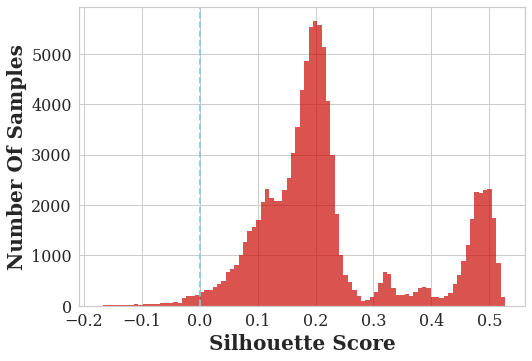

In [29]:
sample_scores.sort()
plt.hist(sample_scores, bins = 'rice', color='r', alpha=0.7)
x_label, y_label = 'Silhouette Score', 'Number Of Samples'
style_image(x_label, y_label)
plt.axvline(x=0, color='c', alpha=1, linestyle = '--')
plt.savefig('anom_sil.svg')

## External Varaible & Anomalies 

In [40]:
anomalies_threshold = 0

batch = batches[0]
anomalies = batch[batch.sil_score < anomalies_threshold]
anomaly_inds = list(batch[batch.sil_score < anomalies_threshold].index)
for batch in batches[1:]:
  anomalies = anomalies.append(batch[batch.sil_score < anomalies_threshold])
  anomaly_inds.extend(batch[batch.sil_score < anomalies_threshold].index)

In [41]:
anomalies_external_vars = data.loc[anomaly_inds,["dAge", "dHispanic", "iYearwrk", "iSex"]].astype('int32')
data_in_numeric_type = data.astype('int32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


dAge: KL divergence = 76.69393540895484
dHispanic: KL divergence = 0.9756112518149229
iYearwrk: KL divergence = 85.19975369628578
iSex: KL divergence = 4.154924501323643


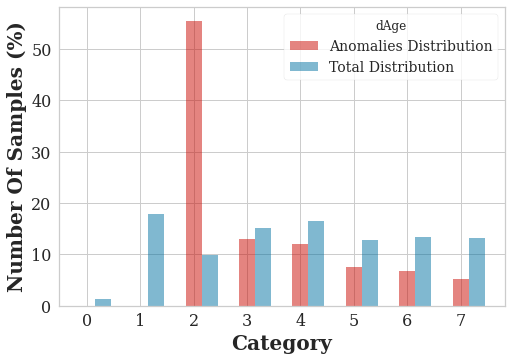

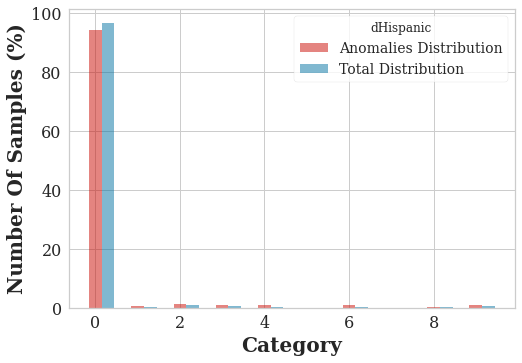

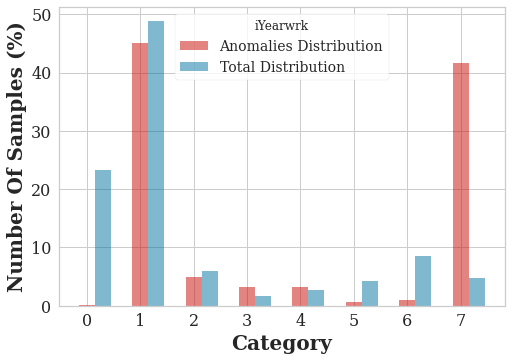

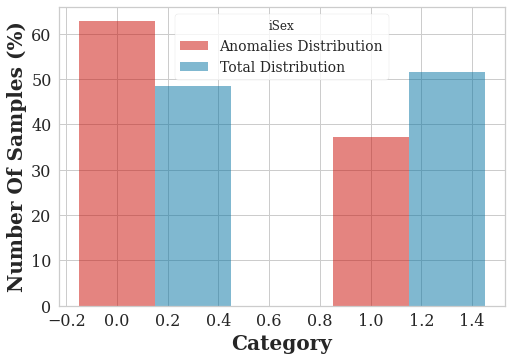

In [42]:
external_var_names = ["dAge", "dHispanic", "iYearwrk", "iSex"]
external_var_range = [8, 10, 8, 2]
width = 0.3
x_label, y_label = 'Category', 'Number Of Samples (%)'

anomalies_rate = len(anomalies_external_vars)/len(data)
for ext_v_name, ext_r in zip(external_var_names, external_var_range):
  plt.figure()
  
  data_cnt = []
  anomalies_cnt = []
  tot_num_anom = len(anomalies_external_vars)
  for i in range(ext_r):
    i_num_data = len(data[data[ext_v_name] == str(i)])
    data_cnt.append(100*i_num_data/len(data))
    i_num_anom = len(anomalies_external_vars[anomalies_external_vars[ext_v_name] == i])
    anomalies_cnt.append(100*i_num_anom/tot_num_anom)

  plt.bar(list(range(ext_r)), anomalies_cnt, width, color='r', alpha=0.5, label="Anomalies Distribution")
  plt.bar([x+width for x in range(ext_r)], data_cnt, width, color='b', alpha=0.5, label="Total Distribution")
  p = np.array(anomalies_cnt)
  q = np.array(data_cnt)
  
  kl_div_result = kl_divergence(p, q)
  print(f'{ext_v_name}: KL divergence = {kl_div_result}')
  style_image(x_label, y_label)
  plt.legend(title= ext_v_name, frameon=True, prop={'size': 14})
  plt.savefig(f'{ext_v_name}_dist_anom_vs_norm.svg')

# Reduce Dimension

In [ ]:
def isomap_reduction(x_data, n_neighbors=5):
    embedding = Isomap(n_components=2, n_neighbors=n_neighbors)
    converted_data = embedding.fit_transform(x_data)
    return converted_data
    
    
def pca_reduction(x_data):
    pca = PCA(2)  # we need 2 principal components.
    converted_data = pca.fit_transform(x_data)
    return converted_data


def laplacian_reduction(x_data):
    embedding = SpectralEmbedding(n_components=2)
    converted_data = embedding.fit_transform(x_data)
    return converted_data


def lle_reduction(x_data, n_neighbors=12):
    embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors, method="modified")
    converted_data = embedding.fit_transform(x_data)
    return converted_data


def cmds_reduction(x_data):
    dist_metric = euclidean_distances(x_data)
    mds = MDS(metric=True, dissimilarity='precomputed', random_state=0)  # we need 2 principal components.
    converted_data = mds.fit_transform(dist_metric)
    return converted_data


def tsne_reduction(x_data, n_neighbors=5):
    embedding = TSNE(n_components=2, learning_rate='auto', init='random')
    converted_data = embedding.fit_transform(x_data)
    return converted_data


def ica_reduction(x_data, n_neighbors=5):
    embedding = FastICA(n_components=7, random_state=0)
    converted_data = embedding.fit_transform(x_data)
    return converted_data


In [ ]:
i = 0
iso_reduced_data = isomap_reduction(batches[i])
# cmds_reduced_data = cmds_reduction(batches[i])
# pca_reduced_data = pca_reduction(batches[i])
# lap_reduced_data = laplacian_reduction(batches[i])
# lle_reduced_data = lle_reduction(batches[i])
tsne_reduced_data = tsne_reduction(batches[i])
# ica_reduced_data = ica_reduction(batches[i])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
# for reduce_data in [iso_reduced_data, cmds_reduced_data, pca_reduced_data, lap_reduced_data, lle_reduced_data, tsne_reduced_data, ica_reduced_data ]:  
#   plt.figure()
#   c_map = plt.cm.get_cmap('jet', 12)
#   plt.scatter(reduce_data[:,0],reduce_data[:,1],c=cluster_by_method['KMEANS'][0],cmap=c_map)
#   plt.colorbar()

0
1
2


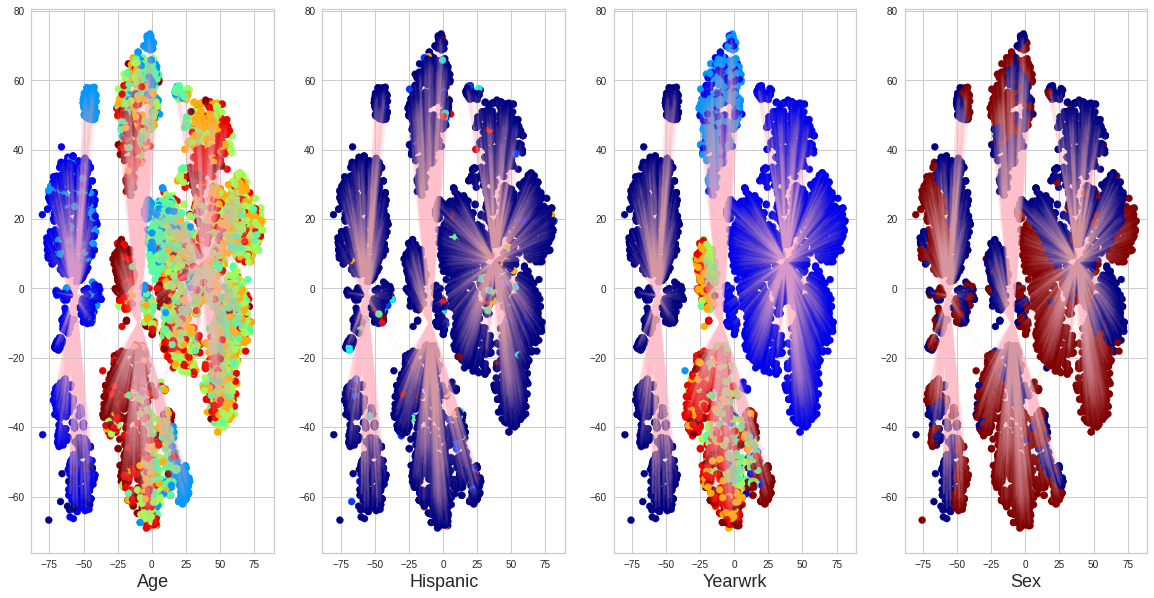

In [ ]:
# iso_reduced_data,pca_reduced_data, lap_reduced_data, lle_reduced_data ,tsne_reduced_data, ica_reduced_data

fig, axes= plt.subplots(1, 4, figsize=(20,10))


labels = clusters_by_method['GMM'][0]
points = tsne_reduced_data #change to tsne_reduced_data

# for l,c in zip(np.unique(labels),['green','red','yellow','purple','blue']):
for l in np.unique(labels):
  if l==-1:
    continue
  print(l)
  cluster = points[labels==l]
  center = np.mean(cluster, axis=0)

  for point in cluster:
      x = [point[0], center[0]]
      y = [point[1], center[1]]
      axes[0].plot(x, y, 'pink', alpha=0.022, linewidth=2)
      axes[1].plot(x, y, 'pink', alpha=0.022, linewidth=2)
      axes[2].plot(x, y, 'pink', alpha=0.022, linewidth=2)
      axes[3].plot(x, y, 'pink', alpha=0.022, linewidth=2)

c_map = plt.cm.get_cmap('jet', 12)
axes[0].scatter(points[:,0],points[:,1],c=np.array(external_veriable[0]["dAge"], dtype=int),cmap=c_map) #["dAge", "dHispanic", "iYearwrk", "iSex"]
axes[0].set_xlabel('Age',fontsize=18)

c_map = plt.cm.get_cmap('jet', 12)
axes[1].scatter(points[:,0],points[:,1],c=np.array(external_veriable[0]["dHispanic"], dtype=int),cmap=c_map) #["dAge", "dHispanic", "iYearwrk", "iSex"]
axes[1].set_xlabel('Hispanic',fontsize=18)

c_map = plt.cm.get_cmap('jet', 12)
axes[2].scatter(points[:,0],points[:,1],c=np.array(external_veriable[0]["iYearwrk"], dtype=int),cmap=c_map) #["dAge", "dHispanic", "iYearwrk", "iSex"]
axes[2].set_xlabel('Yearwrk',fontsize=18)

c_map = plt.cm.get_cmap('jet', 12)
axes[3].scatter(points[:,0],points[:,1],c=np.array(external_veriable[0]["iSex"], dtype=int),cmap=c_map) #["dAge", "dHispanic", "iYearwrk", "iSex"]
axes[3].set_xlabel('Sex',fontsize=18)

plt.savefig('tsne.pdf') #change to tsne
plt.show()

0
1
2


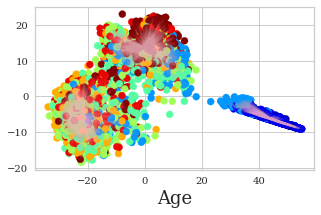

In [ ]:
labels = clusters_by_method['GMM'][0]
points = iso_reduced_data #change to tsne_reduced_data

fig, ax = plt.subplots(figsize=(8,5)) 
# for l,c in zip(np.unique(labels),['green','red','yellow','purple','blue']):
for l in np.unique(labels):
  if l==-1:
    continue
  print(l)
  cluster = points[labels==l]
  center = np.mean(cluster, axis=0)

  for point in cluster:
      x = [point[0], center[0]]
      y = [point[1], center[1]]
      ax.plot(x, y, 'pink', alpha=0.022, linewidth=2)

c_map = plt.cm.get_cmap('jet', 12)
ax.scatter(points[:,0],points[:,1],c=np.array(external_veriable[0]["dAge"], dtype=int),cmap=c_map) #["dAge", "dHispanic", "iYearwrk", "iSex"]
plt.xlabel('Age',fontsize=18)


plt.savefig('iso_Age.svg') 
plt.show()